**Problem 2 b) DermaMNIST  - Transfer Learning**

In [1]:
# import necessary libraries

!pip install medmnist

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from medmnist import DermaMNIST
from tensorflow.keras.applications import VGG19
from medmnist import Evaluator
import torchvision.transforms as transforms



2025-03-22 00:16:18.811184: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 00:16:18.821916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742602578.834550  236516 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742602578.838144  236516 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742602578.847304  236516 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Loading the dataset
train_dataset = DermaMNIST(split="train", download=True)
val_dataset = DermaMNIST(split="val", download=True)
test_dataset = DermaMNIST(split="test", download=True)


Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz
Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz
Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz


In [3]:
# Original labels - Before one-hot encoding
print("Original label shape:", train_dataset.labels.shape)
print("First 5 labels:", train_dataset.labels[:5].flatten())

# labels shape - After one-hot encoding
labels_encoded = tf.keras.utils.to_categorical(train_dataset.labels, num_classes=7)
print("One-hot encoded label shape:", labels_encoded.shape)
print("First 5 one-hot encoded labels:\n", labels_encoded[:5])



Original label shape: (7007, 1)
First 5 labels: [0 5 5 5 4]
One-hot encoded label shape: (7007, 7)
First 5 one-hot encoded labels:
 [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [4]:
from skimage.transform import resize

# Resizing function for 32x32
def resize_images(images, new_shape):
    resized = np.zeros((images.shape[0], *new_shape))
    for i, img in enumerate(images):
        resized[i] = resize(img, new_shape)
    return resized

def prepare_data_for_vgg(dataset):
    images = dataset.imgs / 255.0
    images_resized = resize_images(images, (32, 32, 3))  # Resize to 32x32x3
    labels = tf.keras.utils.to_categorical(dataset.labels, num_classes=7)
    return images_resized, labels

x_train, y_train = prepare_data_for_vgg(train_dataset)
x_val, y_val = prepare_data_for_vgg(val_dataset)
x_test, y_test = prepare_data_for_vgg(test_dataset)


In [5]:
from sklearn.utils import class_weight

# Converting the one-hot encoded values to class labels
y_train_labels = np.argmax(y_train, axis=1)

# Computing class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 4.390350877192983, 1: 2.788300835654596, 2: 1.3016905071521456, 3: 12.5125, 4: 1.2849807445442876, 5: 0.21329639889196675, 6: 10.11111111111111}


2025-03-22 00:16:24.122164: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/150
110/110 - 10s - 92ms/step - accuracy: 0.2582 - loss: 6.1284 - val_accuracy: 0.1844 - val_loss: 2.8749
Epoch 2/150
110/110 - 10s - 92ms/step - accuracy: 0.3133 - loss: 3.3215 - val_accuracy: 0.3988 - val_loss: 1.9184
Epoch 3/150
110/110 - 9s - 86ms/step - accuracy: 0.3491 - loss: 3.1023 - val_accuracy: 0.5523 - val_loss: 1.3823
Epoch 4/150
110/110 - 10s - 86ms/step - accuracy: 0.3918 - loss: 2.2775 - val_accuracy: 0.6062 - val_loss: 1.3022
Epoch 5/150
110/110 - 10s - 88ms/step - accuracy: 0.3765 - loss: 2.5226 - val_accuracy: 0.4327 - val_loss: 1.6112
Epoch 6/150
110/110 - 11s - 104ms/step - accuracy: 0.4471 - loss: 1.7966 - val_accuracy: 0.3539 - val_loss: 1.8526
Epoch 7/150
110/110 - 9s - 86ms/step - accuracy: 0.4665 - loss: 1.7020 - val_accuracy: 0.4487 - val_loss: 1.6585
Epoch 8/150
110/110 - 9s - 86ms/step - accuracy: 0.4407 - loss: 1.7039 - val_accuracy: 0.6500 - val_loss: 1.0588
Epoch 9/150
110/110 - 11s - 96ms/step - accuracy: 0.4889 - loss: 1.5838 - val_accuracy: 0.

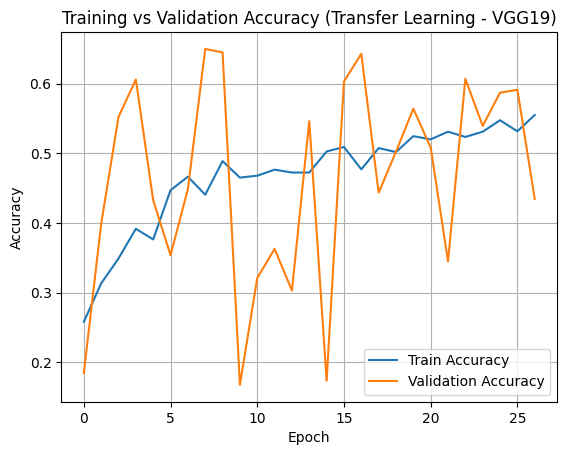

In [6]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# Resize inputs to 32x32x3 to be compatible with VGG19
def resize_images(images, new_shape=(32, 32)):
    resized = tf.image.resize(images, new_shape)
    return resized

x_train_resized = resize_images(x_train)
x_val_resized = resize_images(x_val)
x_test_resized = resize_images(x_test)

# Loading VGG19 model with weights, excluding the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Drop layers after 'block4_conv1'
cut_layer = base_model.get_layer('block4_conv1').output

# added Global Average Pooling and Output Layer
x = GlobalAveragePooling2D()(cut_layer)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

# the final model
model_vgg = Model(inputs=base_model.input, outputs=output)

# Freeze all layers in base VGG model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_vgg = model_vgg.fit(
    x_train_resized, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(x_val_resized, y_val),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=2
)

# Plot accuracy curves
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Transfer Learning - VGG19)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
#model's summary
model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,431 (14.14 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 3,505,728 (13.37 MB)

 Optimizer params: 133,136 (520.07 KB)

- This model uses the **VGG-19 architecture** and stops at the block4_conv1 layer.
- On top of that we have added a **Global Average Pooling layer**, a Dense layer with 128 neurons, and a final output layer with 7 classes.
- All the layers in the model from the VGG-19 base are frozen, so only the new layers are trained.
- The model has around 3,705,431 total parameters out of which only 66,567 are trainable parameters while the rest 3,505,728 are non trainable parameters, suggesting that a lot of parameters are missed.

**Hyperparameters used**


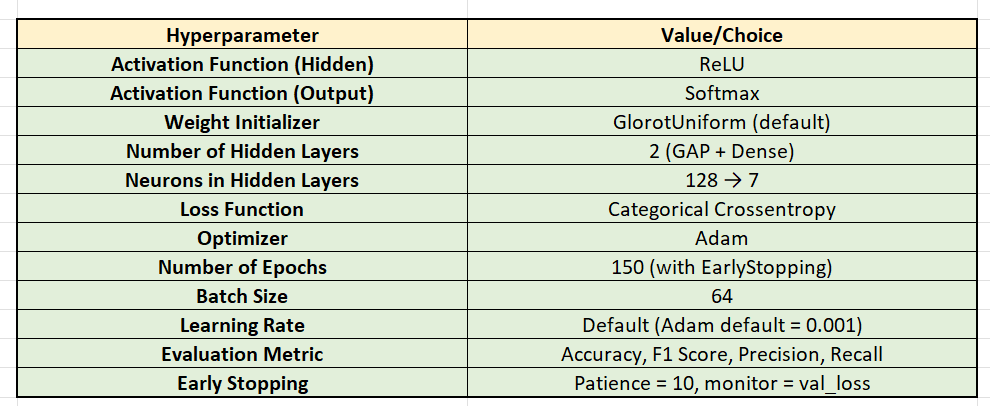

In [8]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_pred = model_vgg.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

test_loss, test_acc = model_vgg.evaluate(x_test, y_test, verbose=0)

# Evaluation  metrics
print("\n--- Metrics for VGG-19 Transfer Learning Model ---")
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")
print(f"F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.5f}")
print(f"Precision: {precision_score(y_true, y_pred_classes, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_true, y_pred_classes, average='weighted'):.5f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

--- Metrics for VGG-19 Transfer Learning Model ---
Test Loss: 1.01812
Test Accuracy: 0.64090
F1 Score: 0.66759
Precision: 0.71411
Recall: 0.64090


**Analysis:**
- The VGG-19-based transfer learning model achieved a low test accuracy( 64.09% ) in comparsion to the earlier 2a) CNN model. And this model has an F1 score of 66.75%, indicating moderate performance.
- The use of pre-trained features helped the model generalize better, especially with limited training data.
- However, since only a small portion of the network was trainable, the model may not have fully adapted to the DermaMNIST dataset's domain, leading to limited improvement. Adding fine-tuning or more custom layers could enhance performance further.